In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from tqdm import tqdm

In [3]:
class SpecificSoftmaxMSE():

    def __init__(self, neuron, y_true=0, dim=1):
        """
        Args:
        Name     Type    Desc
        neuron:  int     The output neuron to minimize
        y_true   float   The desired activation
        dim      int     The softmax axis. Default is one for tensor with shape (n_batches, n_classes)
        """
        super().__init__()
        self.neuron = neuron
        self.y_true = y_true
        self.logits = nn.Softmax(dim=dim)

    """
    Compute the MSE after computing the softmax of input.
    Forward is implemented in the __call__ method of super
    """
    def forward(self, y_pred):
        """
        Args
        y_pred  torch.tensor The output of the networ. Preferable shape (n_batch, n_classes)
        """
        if len(y_pred.shape) == 1:
            y_pred = y_pred.reshape(1, -1)
        return 0.5*(self.y_true - self.logits(y_pred)[:, self.neuron])**2
    
    def __call__(self, x):
        return self.forward(x)

In [151]:
class InexactZSCG(object):
    """
    Args:
    Name            Type                Description
    model:          (nn.Module)         The model to use to get the output
    loss:           (nn.Module)         The loss to minimize
    device:
    """
    def __init__(self, model, loss, device=torch.device('cuda')):
        self.device = device
        self.loss = loss
        self.model = model.to(self.device)
        self.model.eval()


    def run(self, x, v, mk, gamma_k, mu_k, epsilon,
            C = (0, 1) , max_steps=100, stop_criterion=1e-3,
            verbose=0, additional_out=False, tqdm_disabled=False):
        """
        Args:
        Name            Type                Description
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        v:              (float)             The gaussian smoothing
        mk:             (list)              Number of normal vector to generate at every step
        gamma_k         (list)              Pseudo learning rate inside ICG at every step
        mu_k            (list)              Stopping criterion inside ICG at every step
        epsilon:        (float)             The upper bound of the infinity norm
        C:              (tuple)             The boundaires of the pixel. Default is (0, 1)
        max_steps:      (int)               The maximum number of steps. Default is 100
        stop_criterion  (float)             The minimum loss function. Default is 1e-3
        verbose:        (int)               Display information or not. Default is 0
        additional_out  (bool)              Return also all the x. Default is False
        tqdm_disable    (bool)              Disable the tqdm bar. Default is False
        """
        x = x.to(self.device)

        # 1. Init class attributes
        self.create_boundaries(x, epsilon, C) # Set x_original min and max
        self.dim = x.shape
        self.total_dim = torch.prod(torch.tensor(x.shape))
        self.epsilon = epsilon

        # 2. Init list of results
        losses, outs = [], [] # List of losses and outputs

        # 3. Main optimization cycle
        for ep in tqdm(range(max_steps), disable=tqdm_disabled):
            if verbose:
                print("---------------")
                print("Step number: {}".format(ep))
            # 3.1 Call the step
            x, gk = self.step(x, v, gamma_k[ep], mu_k[ep], mk[ep], verbose)
            x = x.reshape(self.dim[0], self.dim[1], self.dim[2]).detach()
            # 3.2 Compute loss
            out = self.model(x.view(1, self.dim[0], self.dim[1], self.dim[2]))
            loss = self.loss(out)
            # 3.3 Save results
            losses.append(loss.detach().cpu().item())
            outs.append(out.detach().cpu()[0, self.loss.neuron].item())
            # 3.4 Display current info
            if verbose:
                print("Loss:        {}".format(losses[-1]))
                print("Output:      {}".format(outs[-1]))
            # 3.5 Check Stopping criterion
            # Flag if loss is very low
            condition1 = loss < stop_criterion
            # Flag if we wanted to minimize the output of a neuron and the prediction is now different
            condition2 = (int(torch.argmax(out)) != self.loss.neuron) and (self.loss.y_true == 0)
            # Flag if we wanted to maximise the output of a neuron and now the neuron has the greatest activation
            condition3 = (int(torch.argmax(out)) == self.loss.neuron) and (self.loss.y_true == 1)
            if condition1 or condition2 or condition3:
                            break

        return  x, losses, outs

    """
    Do an optimization step
    """
    def step(self, x, v, gamma, mu, mk, verbose=0):
        """
        Args:
        Name            Type                Description
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        v:              (float)             The gaussian smoothing
        gamma:          (float)             The update parameters of g
        mu:             (float)             The stopping criterion
        mk:             (int)               The number of Gaussian Random Vector to generate
        verbose:        (bool)              Display information or not. Default is 0
        """
        # Compute the approximated gradient
        g = self.compute_Gk(x, v, mk, verbose)
        # Call the inexact conditional gradient
        x_new = self.compute_ICG(x, g, gamma, mu, verbose).reshape(x.shape[0], x.shape[1], x.shape[2])

        if verbose > 1:
            print("\nINSIDE STEP")
            print("Gradient has shape: {}".format(g.shape))
            print("Gradient is:\n{}".format(g))
            print("x_new has shape: {}".format(x_new.shape))
            print("x_new is:\n{}".format(x_new))

        return x_new.detach(), g.detach()

    """
    Compute the Gv(x(k-1), chi(k-1), u(k)) in order to compute an approximation of the gradient of f(x(k-1), chi(k-1))
    """
    def compute_Gk(self, x, v, mk, verbose=0):
        """
        Args:
        Name            Type                Description
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        v:              (float)             The gaussian smoothing
        verbose:        (bool)              Display information or not. Default is 0
        """
        # 1. Create x(k-1) + v*u(k-1)
        uk     = torch.empty(mk, self.total_dim).normal_(mean=0, std=1).to(self.device) # Dim (mk, channel*width*height)
        img_u  = uk.reshape(mk, self.dim[0], self.dim[1], self.dim[2])                  # Dim (mk, channel, width, height)
        img_x  = x.expand(mk, self.dim[0], self.dim[1], self.dim[2])                    # Dim (mk, channel, width, height)
        m_x    = (img_x + v*img_u)                                                      # Dim (mk, channel, width, height)

        if verbose > 1:
            print('\nINSIDE GRADIENT')
            print('The Gaussian vector uk has shape:\t{}'.format(uk.shape))
            print('The input x has shape:\t\t\t{}'.format(x.shape))
            print('The input x + vu has shape:\t\t{}'.format(m_x.shape))

        # 2. Get objective functions
        standard_loss = self.loss(self.model(x.view(1, x.shape[0], x.shape[1], x.shape[2])))         # Dim (1)
        gaussian_loss = self.loss(self.model(m_x))                                                   # Dim (mk)

        # 3. Compute Gv(x(k-1), chi(k-1), u(k))
        fv = ((gaussian_loss - standard_loss.expand(uk.shape[0]))/v).view(-1, 1)                     # Dim (mk, 1)
        
        if verbose > 1:
            print('The standard (expand) loss has shape:\t{}'.format(standard_loss.expand(uk.shape[0]).shape))
            print('The gaussian loss has shape:\t\t{}'.format(gaussian_loss.shape))
            print('The total function fv has shape:\t{}'.format(fv.shape))
            
        G = fv * uk                                                                     # Dim (mk, channel*width*height)

        return torch.mean(G, axis=0).detach()

    """
    Compute the Inexact Condtion Gradient (Algorothm 3 of source article)
    """
    def compute_ICG(self, x, g, gamma, mu, verbose):
        """
        Args:
        Name            Type                Description
        x:              (torch.tensor)      The variable of our optimization problem. Should be a 3D tensor (img)
        g:              (torch.tensor)      The approximated gradient. Should be a 1D tensor
        gamma:          (float)             The update parameters of g
        mu:             (float)             The stopping criterion
        """
        # 1. Init variables
        y_old = x.view(-1).clone() # dim = (n_channel * width * height)
        u = torch.rand(self.total_dim).to(self.device)*(self.max.view(-1) - self.min.view(-1)) + self.min.view(-1)
        t = 1
        k = 0

        # 2. Main cycle
        while(k==0):
            # 2.1 Compute gradient
            grad = g + gamma*(y_old - x.view(-1))
            # 2.2 Move to the boundaries in one shot
            y_new = self.check_boundaries(self.x_original.view(-1) - self.epsilon*torch.sign(grad))
            # 2.3 Compute new function value
            h = torch.dot(grad, y_new - y_old)

            if verbose > 1:
                print('\nINSIDE ICG')
                print('Time t = {}'.format(t))
                print('The ICG gradient is:\n{}'.format(grad))
                print('The new y is:\n {}'.format(y_new))
                print('The function h(y_new) is {}'.format(h))
                print('Mu is: {}'.format(mu))
            # 2.4 Check conditions
            if h >= -mu:
                k = 1
            else:
                y_old = (t-1)/(t+1)*y_old + 2/(t+1)*y_new
                t += 1

        return y_old.detach()

    """
    Create the boundaries of our constraint optimization problem
    """
    def create_boundaries(self, x, epsilon, C):
        """
        Args:
        Name            Type                Description
        x:              (torch.tensor)      The original image. Should be a 3D tensor (img)
        epsilon:        (float)             The maximum value of ininity norm.
        """
        self.x_original = x.clone().to(self.device)           # dim = (n_channel, width, height)
        self.max = (self.x_original+epsilon).to(self.device)  # dim = (n_channel, width, height)
        self.min = (self.x_original-epsilon).to(self.device)  # dim = (n_channel, width, height)
        self.C = C
        self.max[self.max > C[1]] = C[1]
        self.min[self.min < C[0]] = C[0]

    """
    Check the boundaries of our constraint optimization problem
    """
    def check_boundaries(self, x):
        x[x > self.C[1]] = self.C[1]
        x[x < self.C[0]] = self.C[0]
        return x

In [194]:
class SinModel(nn.Module):
    
    def __init__(self, A, shift):
        super().__init__()
        self.A = A
        self.shift = shift
    
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        if torch.prod(torch.tensor(x.shape)) == 1:
            return torch.sin(self.A*x + self.shift).view(-1)
        else:
            return torch.sin(self.A*x + self.shift).view(-1, 1)
            
    
class SinMSELoss():
    
    def __init__(self, neuron=0, y_true=-1):
        self.neuron = neuron
        self.y_true = y_true
        
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        return (0.5*(self.y_true - x)**2).view(-1)
    
loss_fn = SinMSELoss(neuron=0, y_true=-1)
net = SinModel(A=10, shift=2)

In [195]:
x = torch.tensor([1]).reshape(1, 1, 1, 1).float()
print(net(x))

tensor([-0.5366])


In [202]:
out = net(torch.arange(-1, 2, step=0.01))
loss_curve = loss_fn(out)
C = (0, 1)        
original_x = torch.tensor([0.5])

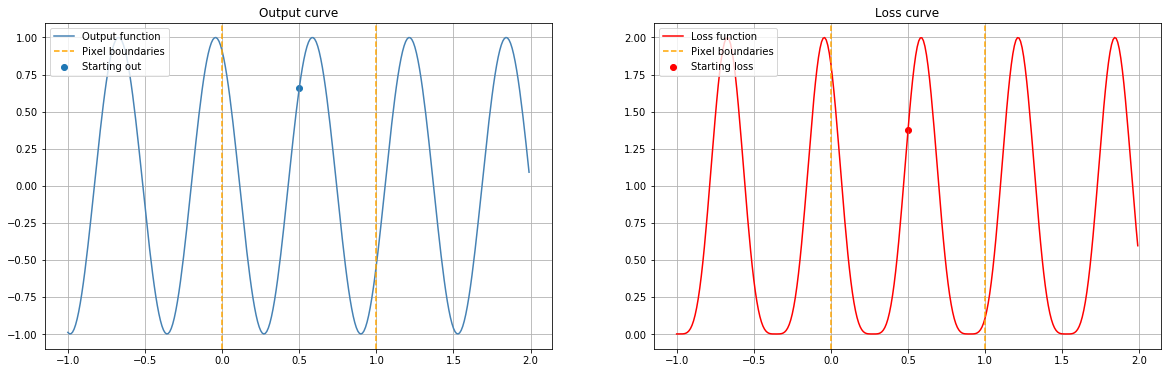

In [203]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(torch.arange(-1, 2, step=0.01), out, color='steelblue', label='Output function')
ax[0].scatter(original_x, net(original_x), label='Starting out')
ax[0].axvline(C[0], color='orange', linestyle='--', label='Pixel boundaries')
ax[0].axvline(C[1], color='orange', linestyle='--')
ax[0].set_title('Output curve')
ax[0].legend(loc='upper left')
ax[0].grid()

ax[1].plot(torch.arange(-1, 2, step=0.01), loss_curve, color='red', label='Loss function')
ax[1].scatter(original_x, loss_fn(net(original_x)), color='red', label='Starting loss')
ax[1].axvline(C[0], color='orange', linestyle='--', label='Pixel boundaries')
ax[1].axvline(C[1], color='orange', linestyle='--')
ax[1].set_title('Loss curve')
ax[1].legend(loc='upper left')
ax[1].grid()
plt.show()

In [217]:
N = 5
d = torch.prod(torch.tensor(original_x.shape))

params = {'x':              original_x.view(1, 1, 1),
          'v':              0.01,
          'mk':             [6*(d+5)*N]*N,
          'gamma_k':        [1]*N,
          'mu_k':           [1/(5*N)]*N,
          'epsilon':        20,
          'max_steps':      N,
          'stop_criterion': 1e-1,
          'verbose':        2
         }

In [218]:
device = torch.device('cuda')
optim = InexactZSCG(model=net, loss=loss_fn)
x_new, losses, outs = optim.run(**params)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

---------------
Step number: 0

INSIDE GRADIENT
The Gaussian vector uk has shape:	torch.Size([180, 1])
The input x has shape:			torch.Size([1, 1, 1])
The input x + vu has shape:		torch.Size([180, 1, 1, 1])
The standard (expand) loss has shape:	torch.Size([180])
The gaussian loss has shape:		torch.Size([180])
The total function fv has shape:	torch.Size([180, 1])

INSIDE ICG
Time t = 1
The ICG gradient is:
tensor([12.1089], device='cuda:0')
The new y is:
 tensor([0.], device='cuda:0')
The function h(y_new) is -6.054452896118164
Mu is: 0.04

INSIDE ICG
Time t = 2
The ICG gradient is:
tensor([11.6089], device='cuda:0')
The new y is:
 tensor([0.], device='cuda:0')
The function h(y_new) is 0.0
Mu is: 0.04

INSIDE STEP
Gradient has shape: torch.Size([1])
Gradient is:
tensor([12.1089], device='cuda:0')
x_new has shape: torch.Size([1, 1, 1])
x_new is:
tensor([[[0.]]], device='cuda:0')


IndexError: too many indices for tensor of dimension 1

In [163]:
net = net.cpu()
out_new =  net(torch.tensor([x_new]).view(1, 1, 1, 1).float())[0, n]

plt.figure(figsize = (10, 5))
plt.plot(xs, outs1, label = 'Output function')
plt.axvline(original_x + 20, linestyle='--', color='orange', label = 'Boundaires')
plt.axvline(original_x -20, linestyle='--', color='orange')
plt.scatter(original_x, original_out[n], label='Starting point')
plt.scatter(x_new.cpu().detach(), out_new.cpu().detach(), label='Ending point')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Out')
plt.grid()

NameError: name 'x_new' is not defined



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00, 15.33it/s]

---------------
Step number: 0

INSIDE GRADIENT
The Gaussian vector uk has shape:torch.Size([180, 1])
The input x has shape:		torch.Size([1, 1, 1])
The input x + vu has shape:	torch.Size([180, 1, 1, 1])

INSIDE ICG
Time t = 1
The ICG gradient is:
tensor([-0.0001], device='cuda:0')
The new y is:
 tensor([40.7626], device='cuda:0')
The function h(y_new) is -0.002753846812993288
Mu is: 0.05

INSIDE STEP
Gradient has shape: torch.Size([1])
Gradient is:
tensor([-0.0001], device='cuda:0')
x_new has shape: torch.Size([1, 1, 1])
x_new is:
tensor([[[40.7626]]], device='cuda:0')
Loss:        0.022420747205615044
Output:      0.0001640405534999445
---------------
Step number: 1

INSIDE GRADIENT
The Gaussian vector uk has shape:torch.Size([180, 1])
The input x has shape:		torch.Size([1, 1, 1])
The input x + vu has shape:	torch.Size([180, 1, 1, 1])

INSIDE ICG
Time t = 1
The ICG gradient is:
tensor([3.6002e-06], device='cuda:0')
The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new)



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:00<00:00, 11.34it/s]


The function h(y_new) is -15.86327075958252
Mu is: 0.05

INSIDE ICG
Time t = 3
The ICG gradient is:
tensor([0.1299], device='cuda:0')
The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new) is -1.7322018146514893
Mu is: 0.05

INSIDE ICG
Time t = 4
The ICG gradient is:
tensor([0.0632], device='cuda:0')
The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new) is -0.4216564893722534
Mu is: 0.05

INSIDE ICG
Time t = 5
The ICG gradient is:
tensor([0.0366], device='cuda:0')
The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new) is -0.14632722735404968
Mu is: 0.05

INSIDE ICG
Time t = 6
The ICG gradient is:
tensor([0.0232], device='cuda:0')
The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new) is -0.06199592724442482
Mu is: 0.05

INSIDE ICG
Time t = 7
The ICG gradient is:
tensor([0.0156], device='cuda:0')
The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new) is -0.02977033331990242
Mu is: 0.05

INSIDE STEP
Gradien



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:00<00:00,  8.94it/s]


The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new) is -0.4171693027019501
Mu is: 0.05

INSIDE ICG
Time t = 5
The ICG gradient is:
tensor([0.0359], device='cuda:0')
The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new) is -0.14363491535186768
Mu is: 0.05

INSIDE ICG
Time t = 6
The ICG gradient is:
tensor([0.0226], device='cuda:0')
The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new) is -0.06020105257630348
Mu is: 0.05

INSIDE ICG
Time t = 7
The ICG gradient is:
tensor([0.0150], device='cuda:0')
The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new) is -0.0284882802516222
Mu is: 0.05

INSIDE STEP
Gradient has shape: torch.Size([1])
Gradient is:
tensor([-0.0041], device='cuda:0')
x_new has shape: torch.Size([1, 1, 1])
x_new is:
tensor([[[0.7626]]], device='cuda:0')
Loss:        0.0649583488702774
Output:      0.5594403147697449
---------------
Step number: 4

INSIDE GRADIENT
The Gaussian vector uk has shape:torch.Size



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]



The new y is:
 tensor([0.7626], device='cuda:0')
The function h(y_new) is -0.02863308973610401
Mu is: 0.05

INSIDE STEP
Gradient has shape: torch.Size([1])
Gradient is:
tensor([-0.0040], device='cuda:0')
x_new has shape: torch.Size([1, 1, 1])
x_new is:
tensor([[[0.7626]]], device='cuda:0')
Loss:        0.0649583488702774
Output:      0.5594403147697449


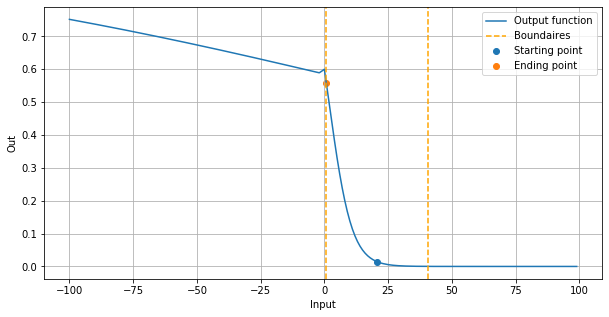

In [348]:
def run_example(epoch, params, bias = 20):
    net = Net()
    original_x = torch.rand(1, 1, 1).float() +20 
    original_out = net(original_x.view(1, 1, 1, 1))[0].data
    
    n = torch.argmin(original_out)
    outs1 = []
    xs = []
    for x in range(-100, 100):
        xs.append(x)
        outs1.append(net(torch.tensor([x]).view(1, 1, 1, 1).float())[0, n])
        
    device = torch.device('cuda')
    loss_fn = SpecificSoftmaxMSE(neuron=n, y_true=0)
    optim = InexactZSGM(model=net, loss=loss_fn)
    x_new, losses, outs = optim.depth_run(**params)
    
    net = net.cpu()
    out_new =  net(torch.tensor([x_new]).view(1, 1, 1, 1).float())[0, n]

    plt.figure(figsize = (10, 5))
    plt.plot(xs, outs1, label = 'Output function')
    plt.axvline(original_x + 20, linestyle='--', color='orange', label = 'Boundaires')
    plt.axvline(original_x -20, linestyle='--', color='orange')
    plt.scatter(original_x, original_out[n], label='Starting point')
    plt.scatter(x_new.cpu().detach(), out_new.cpu().detach(), label='Ending point')
    plt.legend()
    plt.xlabel('Input')
    plt.ylabel('Out')
    plt.grid()
    plt.show()
    


N = 5
d = torch.prod(torch.tensor(original_x.shape))

params = {'x':              original_x,
          'v':              (1/(2*N*(d+3)**3))**0.5,
          'mk':             [6*(d+5)*N]*N,
          'gamma_k':        [0.01]*N,
          'mu_k':           [1/(4*N)]*N,
          'epsilon':        20,
          'max_steps':      N,
          'stop_criterion': 1e-1,
          'verbose':        2
         }

run_example(N, params)